<div style="text-align: left">
    <img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/logo.png?raw=true' width=800/>  
</div>

Author: Itay Segev

E-mail: [itaysegev@campus.technion.ac.il](mailto:itaysegev@campus.technion.ac.il)



# <img src="https://img.icons8.com/?size=50&id=UBsxVQJWKO40&format=png&color=000000" style="height:50px;display:inline"> Actor Critic

<img src='https://static.independent.co.uk/2023/08/11/16/2048x1536.png' width=900/>


<a id="section:intro"></a>

# <img src="https://img.icons8.com/?size=50&id=55412&format=png&color=000000" style="height:50px;display:inline"> Introduction
---

In this notebook, we'll explore the foundation and implementation of **actor-critic methods** in reinforcement learning. Starting with a brief recap of policy gradients, we will discuss the challenges such as high variance, and the solutions including baselines and variance reduction techniques. We’ll delve into the concepts of causality and reward-to-go to enhance policy gradient efficiency. Finally, we'll introduce actor-critic methods, focusing on the **Advantage Actor-Critic** (A2C) algorithm, and demonstrate its application on the classic Pong game.


# <img src="https://img.icons8.com/?size=50&id=43171&format=png&color=000000" style="height:30px;display:inline"> Setup


You will need to make a copy of this notebook in your Google Drive before you can edit the notebook. You can do so with **File &rarr; Save a copy in Drive**.

**Before you start, change to GPU runtime, so rendering cells will run faster.** To do that go to Runtime->Change runtime type->choose T4 GPU and save.
If at some point you get an error that you are out of your GPU quota, you can go back to cpu runtime, some cells will just run slower.

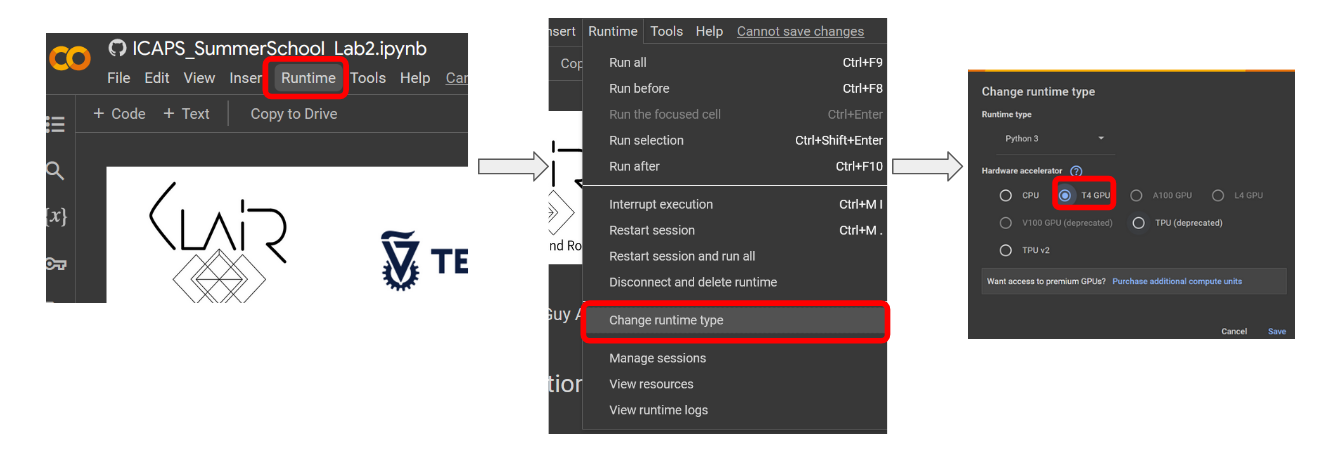

In [ ]:
#@title mount your Google Drive
import os
connect_drive = False #@param {type: "boolean"}
if connect_drive:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # set up mount symlink
  DRIVE_PATH = '/content/gdrive/My\ Drive/cs236203_s24'
  DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
  if not os.path.exists(DRIVE_PYTHON_PATH):
    %mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cs236203_s24'
if not os.path.exists(SYM_PATH) and connect_drive:
  !ln -s $DRIVE_PATH $SYM_PATH




In [ ]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter

#@markdown Double-click on section headers to show code.

from IPython.display import clear_output

!pip install ptan
!pip install tensorboardX
!pip install gymnasium
!pip install gymnasium[accept-rom-license]

clear_output()

In [ ]:
import numpy as np
import os

from collections import deque
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as nn_utils
import torch.optim as optim
from torch.distributions import Categorical
from torch import distributions

# Gym
import gymnasium as gym

# Import necessary libraries
import ptan
from tensorboardX import SummaryWriter





### Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

# <img src="https://img.icons8.com/?size=50&id=42948&format=png&color=000000" style="height:30px;display:inline"> The CartPole-v1 Environment



The [CartPole-v1 environment](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) is a classic control task in reinforcement learning. It is designed to test the basic capabilities of an RL algorithm in a simple yet challenging setting. Here’s a detailed description of the environment:

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart, and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The agent must learn to push the cart left or right **to keep the pole balanced and prevent it from falling over**.


<img src='https://gymnasium.farama.org/_images/cart_pole.gif' width=800/>

## <img src="https://img.icons8.com/?size=50&id=46589&format=png&color=000000" style="height:30px;display:inline"> Task 1: Getting Familiar with the CartPole Environment



<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/task_sign.png?raw=true' width=800/>

In this task, you will explore the CartPole-v1 environment. Your objective is to understand the basic operations of this environment, such as resetting the environment, taking actions, and observing the outcomes.

Questions:
- What are the dimensions of the state space?
- What are the possible actions in the action space?
- What triggers the termination of an episode in CartPole-v1?

In [ ]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)


#### <img src="https://img.icons8.com/?size=50&id=42816&format=png&color=000000" style="height:30px;display:inline">  Solution



In [ ]:
# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

The state space of the CartPole-v1 environment is represented by a 4-dimensional vector:

1. **Cart Position**: The position of the cart along the track.
2. **Cart Velocity**: The velocity of the cart.
3. **Pole Angle**: The angle of the pole with respect to the vertical position.
4. **Pole Angular Velocity**: The rate of change of the pole's angle.

In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

The action space is **discrete**, consisting of two possible actions:

1. **Push Left**: Apply a force to the left.
2. **Push Right**: Apply a force to the right.

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The agent receives a reward 💰 of +1 for every timestep that the pole remains upright. The goal is to maximize the total reward over an episode.

An episode ends if any of the following conditions are met:

- The pole angle exceeds ±12 degrees.
- The cart position exceeds ±2.4 units from the center.
- The episode length exceeds 500 timesteps.

## <img src="https://img.icons8.com/?size=50&id=66365&format=png&color=000000" style="height:30px;display:inline"> Why do we use a simple environment like CartPole-v1?
As explained in [Reinforcement Learning Tips and Tricks](https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html), when you implement your agent from scratch you need **to be sure that it works correctly and find bugs with easy environments before going deeper**. Since finding bugs will be much easier in simple environments.

> Try to have some “sign of life” on toy problems


> Validate the implementation by making it run on harder and harder envs (you can compare results against the RL zoo). You usually need to run hyperparameter optimization for that step.

# <img src="https://img.icons8.com/?size=50&id=T-JFBwgMHsp9&format=png&color=000000" style="height:30px;display:inline"> Recap of Policy Gradients




In this section, we will revisit the key concepts of policy gradients, laying the foundation for understanding actor-critic algorithms. The policy gradient methods are fundamental in reinforcement learning, allowing us to optimize policies directly.

## Policy Based Methods

The main goal of reinforcement learning is to find the optimal policy $\pi^*$ that will maximize the expected cumulative reward. This is based on the [reward hypothesis](https://arxiv.org/pdf/2212.10420): all goals can be described as the maximization of the expected cumulative reward.

In reinforcement learning, policy-based methods are a class of algorithms that directly optimize the policy $\pi_{\theta}(a|s)$, where $\theta$ represents the parameters of the policy, $s$ is the state, and $a$ is the action. These methods differ from value-based methods, which focus on learning a value function and deriving the policy from it. Policy-based methods aim to directly find the optimal policy by maximizing the expected return.

## Overview of Policy Gradients

Policy gradients aim to find the optimal policy by iteratively improving the policy parameters. The main idea is to adjust the policy parameters in the direction that increases the expected reward. This is achieved through gradient ascent on the expected return.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/policy_gradient_one.png' width=800/>

We can interpret the policy gradient update as follows:

- **$\nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t)$**: This term represents the direction of the steepest increase in the (log) probability of selecting action $a_t$ from state $s_t$. It indicates how we should adjust the weights of the policy to increase or decrease the log probability of selecting action $a_t$ at state $s_t$.

- **$R(\tau)$**: This is the scoring function. If the return is high, it will increase the probabilities of the (state, action) combinations. Conversely, if the return is low, it will decrease the probabilities of the (state, action) combinations.

In essence, the policy gradient update modifies the policy parameters $\theta$ to favor actions that lead to higher returns and disfavor actions that lead to lower returns. This approach ensures that the agent learns to take actions that maximize the expected cumulative reward.

### <img src="https://img.icons8.com/?size=50&id=qjEfYyGK_vq-&format=png&color=000000" style="height:30px;display:inline"> The REINFORCE Algorithm (Monte Carlo policy-gradient)




The REINFORCE algorithm, also called Monte Carlo policy-gradient, is a policy-gradient algorithm that uses an estimated return from **an entire episode to update** the policy parameter $\theta$.

<img src='https://core-robotics.gatech.edu/files/2021/01/reinforce.png' width=800/>

### REINFORCE Algorithm Steps:



**1. Sampling Trajectories:**


We start by sampling a batch of trajectories by running the current policy in the environment. This means we generate multiple sequences of states, actions, and rewards by interacting with the environment.


**2. Computing the Policy Gradient:**

Once we have our trajectories, we compute an estimate of the policy gradient. This estimate is calculated by averaging the gradients over all sampled trajectories. Specifically, for each trajectory, we sum the product of the gradient of the log-probability of the actions and the cumulative rewards (reward-to-go) from that point forward.

**3. Gradient Ascent Update:**

Using the computed policy gradient, we perform a gradient ascent step to update the policy parameters. This step involves adding the product of the policy gradient and a learning rate to the current parameter vector, effectively nudging the policy parameters in a direction that increases the expected reward.

#### Why is the REINFORCE Algorithm Also Called Monte Carlo Policy Gradient?

The REINFORCE algorithm is often referred to as Monte Carlo Policy Gradient because it uses Monte Carlo methods to estimate the gradients of the policy. Specifically, it relies on complete episode rollouts to compute the return (total accumulated reward) from each state-action pair. These returns are then used to update the policy parameters. The term "Monte Carlo" signifies the use of random sampling to estimate these returns, capturing the essence of the algorithm's approach to learning optimal policies through trial and error.


# <img src="https://img.icons8.com/?size=50&id=FuA9Gm-EQQqt&format=png&color=000000" style="height:50px;display:inline"> Challenges in Policy Gradient


Policy gradient methods, despite their conceptual simplicity and direct approach to optimizing policies, face several significant challenges that can hinder their practical application.


Though vanilla policy gradient is theoretically simple and mathematically proven, it doesn’t seem to work well in practice. The main reason is because of high variance which policy gradient exhibit. High variance comes from the rewards obtained in a trajectory. Due to inherent randomness present in both environment and policy action selection, the rewards obtained by a fixed policy can vary greatly.

Because of the high variance, we need more trajectories for an accurate estimation of the policy gradient.

### <img src="https://img.icons8.com/?size=50&id=46522&format=png&color=000000" style="height:50px;display:inline"> Sample Inefficency



In order to get anything useful out of policy gradient, **it's necessary to sample from your policy and observe the resultant reward infinte number of times.**

Because we're sampling directly from the policy we're optimizing, we say that policy gradient is an **on-policy** algorithm. If you take a look at the formula for the gradient update, we're calculating an expectation and we're doing that in the Monte Carlo way, by averaging over a number of trial runs. Within that, we have to sum over all the steps in a single trajectory which itself **could be frustratingly expensive to run depending on the nature of the environment** you're working with. So we're iterating sums over sums, and the result is that we incur hugely expensive computational costs in order to acquire anything useful. This works fine in the realms where policy gradient has been successfully applied. If all you're interested in is training your computer to play Atari games, then policy gradient might not be a terrible choice. However, imagine using this process in anything remotely resembling a real-world task, like training a robotic arm to perform open-heart surgery. However, sample inefficiency is not a problem that's unique to policy gradient methods by any means. It's an issue that plagues many different RL algorithms, and addressing this is key to generating a model that's useful in the real world.

## <img src="https://img.icons8.com/?size=50&id=46850&format=png&color=000000" style="height:50px;display:inline"> High Variance



The updates made by the policy gradient are **very high variance**. To get a sense for why this is, first considering that in RL we're dealing with highly general problems such as teaching a car to navigate through an unpredictable environment or programming an agent to perform well across a diverse set of video games.

Therefore, when we're sampling multiple trajectories from our untrained policy we're bound to observe highly variable behaviors. Without any a priori model of the system we're seeking to optimize, **we begin with a policy whose distribution of actions over a given state is effectively uniform**. Of course, as we train the model we hope to shape the probability density so that it's unimodal on a single action, or possibly multimodal over a few successful actions that can be taken in that state. However, **acquiring this knowledge requires our model to observe the outcomes of many different actions taken in many different states**. This is made exponentially worse in continuous action or state spaces as visiting even close to every state-action pair is computationally intractable.

 Due to the fact that we're using Monte Carlo estimates in policy gradient, **we trade off between computational feasibility and gradient accuracy**. It's a fine line to walk, which is why variance reduction techniques can potentially yield huge payoffs.


Another way to think about the variance introduced into the policy gradient update is as follows: at each time step in your trajectory you're observing some stochastic event. Each such event has some noise, and the accumulation of even a small amount of noise across a number of time steps results in a high variance outcome. Yet, understanding this allows us to suggest some ways to alter policy gradient so that the variance might ultimately be reduced.

But collecting large number of trajectories just for a single policy update is infeasible. So researchers have proposed techniques for reducing the variance in policy gradients in the past decades. One common theme across these variance reduction techniques is, they always try to keep the gradient estimate unbiased (equal to its original value).

It’s because, we can solve the variance problem by using large number of samples to estimate the gradient. But with bias, though we’ve infinite number of samples, our policy might converge to a local optimum or not converge at all. That’s why RL researchers are so cautious about it.

<img src='https://balajiai.github.io/assets/variance_visualization.png' width=800/>

Consider two random variables $X$ and $Y$ with the same expectation value  $E(X) = E(Y)$. However, the variance of $X$ is much larger than the variance of $Y$. Therefore, samples drawn from $X$ will be much further away from the expectation value than the ones drawn from $Y$.

In this context, the difference between the sample mean of $X$ and its expectation value will be large. To reduce the variance for accurate estimation of the sample mean, we need to use a large number of samples.

**Note**: The number of samples and the variance both affect the calculation of the sample mean.

#  <img src="https://img.icons8.com/?size=50&id=46671&format=png&color=000000" style="height:50px;display:inline">  Baselines and Variance Reduction



One of the well-known techniques to reduce variance in policy gradient methods is to introduce a baseline. This concept is derived from the control variates method, a popular variance reduction technique used in Monte Carlo methods. In this section, we'll first explain control variates and then derive the baseline from it.

### Control Variates

Control variates are used to reduce the variance of a random variable by introducing another correlated random variable. Let's consider a random variable $X$ with an expectation value $E[X]=\mu$ and high variance $\sigma^2$. Due to the high variance, we require a large number of samples to accurately compute its mean. The control variate method proposes constructing a new random variable $Z$ that has the same expectation value as $X$ ($E[Z]=\mu$) but with lower variance ($\text{Var}(Z)<\text{Var}(X)$).

To construct $Z$, we use the following formula:
$$ Z = X - c(Y - E[Y]) $$
where $c$ is a constant, and $Y$ is another random variable that correlates with $X$. By choosing the right value of $c$, we can ensure that $Z$ has lower variance than $X$.

The optimal value for $c$ that minimizes the variance of $Z$ is:
$$ c = \frac{\text{Cov}(X, Y)}{\text{Var}(Y)} $$

Substituting this value back into the expression for $Z$, we get:
$$ \text{Var}(Z) = \text{Var}(X) - \frac{[\text{Cov}(X, Y)]^2}{\text{Var}(Y)} $$

Since the correlation coefficient $\rho_{XY}$ between $X$ and $Y$ always takes a value between 0 and 1 ($0 \leq \rho_{XY} \leq 1$), we can show that the variance of $Z$ is always less than the variance of $X$.

A special case of the control variate equation is when the constant $c$ takes the value of 1 and $E[Y]=0$:
$$ Z = X - Y $$


### Baseline Technique

The baseline technique uses the above special case of the control variate equation to construct a new policy gradient expression with lesser variance.

The standard policy gradient expression is:
$$ \nabla J(\theta) = E\left[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R_{t} \right] $$

By introducing a baseline $b(s_{t})$, the modified policy gradient expression becomes:
$$ \nabla J(\theta) = E\left[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) (R_{t} - b) \right] $$

We will now prove that the expectation of the newly introduced term into our policy gradient expression is zero, ensuring it does not add any bias. To simplify the proof, we express the policy gradient in terms of trajectories:
$$ \nabla J(\theta) = E\left[\sum_{\tau} \nabla_{\theta} \log \pi_{\theta}(\tau) (R(\tau) - b) \right] $$

Since $E[b(s_{t})] = b$, the expectation term of the baseline is zero, meaning the variance reduction does not bias the gradient.


### Baseline Expression

We've incorporated the baseline into our policy gradient expression and proved that it doesn't add any bias. The next step is finding the baseline expression that achieves minimal variance. The optimal baseline expression is the expected return over trajectories weighted by gradient magnitudes:
$$ b(s_{t}) = \frac{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R_{t}}{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t})} $$

In practice, the average return is often used as a baseline:
$$ b = \frac{1}{N} \sum_{i=1}^{N} R(\tau_{i}) $$

Another commonly used baseline expression is the state-value function $V(s_{t})$. Unlike the average return, which is constant, the state-value function varies depending on the state the agent is in. The generic equation for state-dependent baselines like the state-value function is:
$$ b(s_{t}) = V(s_{t}) $$


### Intuition Behind Baseline

In vanilla policy gradient, the probability of a trajectory $\tau$ is adjusted according to the return $R(\tau)$ during the policy update. With a baseline, the probability is incremented only if $R(\tau) - b(s_{t})$ is positive and decremented if it is negative. In other words, a trajectory's probability is increased only when its return is greater than the average return ($b(s_{t})$).



## REINFORCE with baseline

Before diving into the implementation of the REINFORCE algorithm with a baseline, it's important to set some key hyperparameters. These parameters control various aspects of the learning process and can significantly impact the performance of the algorithm. In this section, we define the following hyperparameters:

In [ ]:
# Hyperparameters
GAMMA = 0.99  # Discount factor for future rewards
LEARNING_RATE = 0.01  # Learning rate for the optimizer
EPISODES_TO_TRAIN = 4  # Number of episodes to collect before training

**EPISODES_TO_TRAIN**: The number of episodes to collect before performing a training step, set to 4. This parameter specifies how many episodes of experience are gathered before updating the policy and value networks.

In this cell, we define the architecture of our Policy Gradient Network (PGN), which is a neural network responsible for approximating the policy. The PGN takes the current state as input and outputs a probability distribution over actions. This distribution is used to sample actions during training and deployment.

In [ ]:
# Define the Policy Gradient Network (PGN)
class PGN(nn.Module):
    def __init__(self, input_size, n_actions):
        super(PGN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In this cell, we define two functions to calculate Q-values (cumulative discounted rewards) from a list of rewards obtained during an episode. **These Q-values are used to update the policy network**.

In [ ]:
# Function to calculate Q-values
def calc_qvals_no_baseline(rewards):
    res = []
    sum_r = 0.0
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    return list(reversed(res))


# Function to calculate Q-values with baseline
def calc_qvals_with_baseline(rewards):
    res = []
    sum_r = 0.0
    for r in reversed(rewards):
        sum_r *= GAMMA
        sum_r += r
        res.append(sum_r)
    res = list(reversed(res))
    mean_q = np.mean(res)
    return [q - mean_q for q in res]

The `train_reinforce` function implements the REINFORCE algorithm with a baseline for training a policy gradient network in a reinforcement learning environment. This function orchestrates the entire training loop, handling the interaction with the environment, collecting and processing experiences, computing Q-values, and updating the policy network. It leverages the PyTorch library for neural network operations and optimization, and `PTAN` (PyTorch Agent Net) for managing experience collection. The function initializes the environment, agent, experience source, and optimizer, and then enters a loop where it continuously collects experiences, computes Q-values using the provided function, and updates the policy network. The updates are performed in batches, and the function logs various metrics to monitor training progress, such as rewards, gradients, and episodes. The function also includes a termination condition to stop training once the agent achieves a satisfactory performance level. This comprehensive approach ensures efficient training of the policy network by reducing variance and stabilizing learning through the use of a baseline and batch updates.

In [ ]:
# Training function
def train_reinforce(env, net, calc_qvals_func, log_dir, episodes_to_train=EPISODES_TO_TRAIN, gamma=GAMMA, lr=LEARNING_RATE):
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=log_dir)

    agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor, apply_softmax=True)
    exp_source = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=gamma)

    optimizer = optim.Adam(net.parameters(), lr=lr)

    total_rewards = []
    step_idx = 0
    done_episodes = 0

    batch_episodes = 0
    batch_states, batch_actions, batch_qvals = [], [], []
    cur_states, cur_actions, cur_rewards = [], [], []

    for step_idx, exp in enumerate(exp_source):
        cur_states.append(exp.state)
        cur_actions.append(int(exp.action))
        cur_rewards.append(exp.reward)

        if exp.last_state is None:
            batch_states.extend(cur_states)
            batch_actions.extend(cur_actions)
            batch_qvals.extend(calc_qvals_func(cur_rewards))
            cur_states.clear()
            cur_actions.clear()
            cur_rewards.clear()
            batch_episodes += 1

        # Handle new rewards
        new_rewards = exp_source.pop_total_rewards()
        if new_rewards:
            done_episodes += 1
            reward = new_rewards[0]
            total_rewards.append(reward)
            mean_rewards = float(np.mean(total_rewards[-100:]))
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d" % (
                step_idx, reward, mean_rewards, done_episodes))
            writer.add_scalar("reward", reward, step_idx)
            writer.add_scalar("reward_100", mean_rewards, step_idx)
            writer.add_scalar("episodes", done_episodes, step_idx)
            if mean_rewards > 195:
                print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
                break

        if batch_episodes < episodes_to_train:
            continue

        # Prepare batches for training
        states_v = torch.FloatTensor(batch_states)
        batch_actions_t = torch.LongTensor(batch_actions)
        batch_qvals_v = torch.FloatTensor(batch_qvals)

        optimizer.zero_grad()
        logits_v = net(states_v)
        log_prob_v = F.log_softmax(logits_v, dim=1)
        log_prob_actions_v = batch_qvals_v * log_prob_v[range(len(batch_states)), batch_actions_t]
        loss_v = -log_prob_actions_v.mean()

        # Backpropagation and optimization
        loss_v.backward()
        grads = np.concatenate([p.grad.data.numpy().flatten()
                            for p in net.parameters()
                            if p.grad is not None])
        optimizer.step()


        grad_max = 0.0
        grad_means = 0.0
        grad_count = 0
        for p in net.parameters():
            grad_max = max(grad_max, p.grad.abs().max().item())
            grad_means += (p.grad ** 2).mean().sqrt().item()
            grad_count += 1

        # Log gradient metrics
        g_l2 = np.sqrt(np.mean(np.square(grads)))
        g_max = np.max(np.abs(grads))
        writer.add_scalar("grad_l2", g_l2, step_idx)
        writer.add_scalar("grad_max", g_max, step_idx)
        writer.add_scalar("grad_var", np.var(grads), step_idx)

        # Clear batches
        batch_episodes = 0
        batch_states.clear()
        batch_actions.clear()
        batch_qvals.clear()

    writer.close()

In [ ]:
# Initialize the environment and network
env = gym.make("CartPole-v0")
net = PGN(env.observation_space.shape[0], env.action_space.n)

In [ ]:
# Train without baseline
train_reinforce(env, net, calc_qvals_no_baseline, log_dir="runs/cartpole_reinforce_no_baseline")

In [ ]:
# Train with baseline
env = gym.make("CartPole-v0")
net = PGN(env.observation_space.shape[0], env.action_space.n)  # Reset the network
train_reinforce(env, net, calc_qvals_with_baseline, log_dir="runs/cartpole_reinforce_with_baseline")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

# <img src="https://img.icons8.com/?size=50&id=4ol5HxFd7R75&format=png&color=000000" style="height:50px;display:inline"> Causality & Reward-To-Go

In this section, we will delve into the concept of reward-to-go and how it serves as an estimation of the Q function in policy gradient methods. Understanding this relationship is crucial for reducing variance in policy gradient estimation and improving the efficiency of reinforcement learning algorithms.


**Causality** states that the policy at time $ t' $ cannot affect the reward at another time step $ t $ if $ t $ is less than $ t' $. In other words, actions in the present cannot change rewards received in the past. This is always true in our universe where time flows forward.


<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/tut04_Don%E2%80%99t_Let_the_Past_Distract_You.png?raw=true' width=800/>

Let's examine our most recent expression for the policy gradient:

$\nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim P_{\theta}(\tau)} \left[ \sum_{t=1}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) R(\tau) \right] $

Taking a step with this gradient pushes up the log-probabilities of each action in proportion to $R(\tau)$, the sum of all rewards ever obtained. But this doesn’t make much sense.

Agents should really only reinforce actions **on the basis of their consequences**. Rewards obtained before taking an action have no bearing on how good that action was: only rewards that come after.




It turns out that this intuition shows up in the [math](https://ai.stackexchange.com/questions/9614/why-does-the-reward-to-go-trick-in-policy-gradient-methods-work), and we can show that the policy gradient can also be expressed by

$ \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim P_{\theta}(\tau)} \left[ \sum_{t=1}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t \mid s_t) \sum_{t'=t}^{T} R(s_{t'}, a_{t'}) \right] $

In this form, actions are only reinforced based on rewards obtained after they are taken.

This new sum, $ \sum_{t'=t}^{T} R(s_{t'}, a_{t'}) $, is known as the **reward-to-go**. It only considers future rewards, which the current action can influence.

#### But how is this better?

A key problem with policy gradients is how many sample trajectories are needed to get a low-variance sample estimate for them. The formula we started with included terms for reinforcing actions proportional to past rewards, **all of which had zero mean, but nonzero variance**: as a result, they would just add noise to sample estimates of the policy gradient. By removing them, we reduce the number of sample trajectories needed.

### REINFORCE with Reward-to-Go Implementation

In this section, we implement the REINFORCE algorithm with reward-to-go. The reward-to-go approach calculates the cumulative future rewards from each time step, rather than the total reward for the entire episode.

In [ ]:
def reinforce(policy, optimizer, env, n_training_episodes, max_t, gamma, print_every):
    scores = []  # List to store scores from each episode
    scores_deque = deque(maxlen=100)  # Deque to store the last 100 scores

    for i_episode in range(1, n_training_episodes + 1):
        state = env.reset()  # Reset the environment and get the initial state
        log_probs = []  # List to store log probabilities of actions taken
        rewards = []  # List to store rewards obtained

        for t in range(max_t):
            action, log_prob = policy.select_action(state)  # Select action using the policy
            state, reward, trunced, terminated, _ = env.step(action)  # Take a step in the environment
            log_probs.append(log_prob)  # Store the log probability of the action
            rewards.append(reward)  # Store the reward obtained

            if trunced or terminated:
                break  # Exit loop if the episode is done

        scores_deque.append(sum(rewards))  # Append total reward for this episode to the deque
        scores.append(sum(rewards))  # Append total reward for this episode to the list

        # Compute the reward-to-go (returns)
        R = 0
        policy_loss = []  # List to store policy loss values
        returns = []  # List to store the returns (cumulative rewards)

        # Implementing the reward-to-go
        for r in rewards[::-1]:  # Calculate cumulative future rewards from each time step
            R = r + gamma * R  # Compute the return
            returns.insert(0, R)  # Insert return at the beginning of the list

        returns = torch.tensor(returns)  # Convert returns to a tensor
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)  # Normalize returns

        # Compute policy loss
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)  # Append the negative log probability scaled by the return

        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        policy_loss = torch.cat(policy_loss).sum()  # Sum up all policy losses
        policy_loss.backward()  # Perform backpropagation
        optimizer.step()  # Update the policy using the optimizer

        # Print average score every `print_every` episodes
        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque)}')

    return scores


### Reward-to-Go as an Estimation of the Q Function

The reward-to-go can be interpreted as an estimate of the Q function. The Q function, $Q_{\pi}(s_{t}, a_{t})$, is defined as the expected return when starting from state $s_{t}$, taking action $a_{t}$, and then following the policy $\pi$:
$$ Q_{\pi}(s_{t}, a_{t}) = E\left[\sum_{t' = t}^{T} R(s_{t'}, a_{t'}) \mid s_{t}, a_{t}, \pi \right] $$

The key difference between the reward-to-go $\hat{R}^{t}$ and the Q function $Q_{\pi}(s_{t}, a_{t})$ is that $\hat{R}^{t}$ is a sample estimate based on a single trajectory, whereas $Q_{\pi}(s_{t}, a_{t})$ is the expected value over all possible trajectories starting from $s_{t}$ and $a_{t}$.

In practice, we use the reward-to-go $\hat{R}^{t}$ as a sample-based approximation of $Q_{\pi}(s_{t}, a_{t})$. This approximation allows us to compute the policy gradient using actual sampled trajectories, making it feasible to implement reinforcement learning algorithms.




### Estimating the Q Function: Monte Carlo and Temporal Difference Methods



Mathematically, this can be represented as:
$$ \nabla J(\theta) = E_{\tau \sim \pi_{\theta}} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) Q_{\pi}(s_{t}, a_{t}) \right] $$

However, in practice, we do not have access to the true Q function, so we need to estimate it. One common method to estimate the Q function is by using the reward-to-go $\hat{R}^{t}$.

**Monte Carlo Estimation:**

The reward-to-go $\hat{R}^{t}$ is calculated at a particular time step $t$ and represents the sum of rewards from that time step to the end of the trajectory:
$$ \hat{R}^{t} = \sum_{t' = t}^{T} R(s_{t'}, a_{t'}) $$

This estimate is then used in the policy gradient computation. While simple to compute, this single sample estimate can be quite far off from the actual expected value due to the inherent randomness in both the policy and the Markov Decision Process (MDP). If we were to land in the same exact state again and run our policy, the outcomes might differ due to this randomness. Consequently, the policy gradient estimate derived from a single sample can exhibit high variance.

The fewer samples you use to estimate an expectation, the higher the variance of your estimator will be. This high variance is a significant problem in policy gradient methods, as it can lead to unstable learning and inefficient updates.

**Temporal Difference (TD) Estimation:**

Another method to estimate the Q function is by using Temporal Difference (TD) learning. In TD learning, we update our estimate of the Q function incrementally, using the observed rewards and the estimated value of the next state:
$$ Q_{\pi}(s_{t}, a_{t}) \approx R(s_{t}, a_{t}) + \gamma V_{\pi}(s_{t+1}) $$

Here, $V_{\pi}(s_{t+1})$ is the value function representing the expected return from state $s_{t+1}$ under the policy $\pi$, and $\gamma$ is the discount factor. The TD update rule is:
$$ Q_{\pi}(s_{t}, a_{t}) \leftarrow Q_{\pi}(s_{t}, a_{t}) + \alpha \left[R(s_{t}, a_{t}) + \gamma V_{\pi}(s_{t+1}) - Q_{\pi}(s_{t}, a_{t}) \right] $$

The advantage of TD methods over Monte Carlo methods is that they use information from the next state to update the current state, leading to potentially lower variance estimates.

# <img src="https://img.icons8.com/?size=50&id=Ny0s87b9nssQ&format=png&color=000000" style="height:50px;display:inline"> Applying Baselines for Further Variance Reduction



In addition to using the Q function, we can apply baselines to further reduce the variance of the policy gradient estimate. A baseline is a value that we subtract from the reward-to-go, which does not introduce any bias but helps in reducing variance.

The most commonly used baselines are the average reward or the state-value function $V(s_{t})$:

**Average Reward Baseline:** This is a constant value representing the average return over all trajectories. By subtracting this constant from the reward-to-go, we reduce the variance because it normalizes the returns. The intuition is that actions leading to returns higher than the average reward are more likely to be beneficial.

**State-Value Function $V(s_{t})$:** Unlike the average reward, which is constant, the state-value function varies depending on the state the agent is in. It represents the expected return from a particular state under the current policy. Using the state-value function as a baseline provides a more accurate and state-specific normalization, further reducing the variance of the policy gradient.

Mathematically, the policy gradient with a baseline $b$ is given by:
$$ \nabla J(\theta) = E_{\tau \sim \pi_{\theta}} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) \left( Q_{\pi}(s_{t}, a_{t}) - b \right) \right] $$

Using a state-value function as a baseline:
$$ b(s_{t}) = V_{\pi}(s_{t}) $$

This makes the gradient estimate:
$$ \nabla J(\theta) = E_{\tau \sim \pi_{\theta}} \left[ \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) A_{\pi}(s_{t}, a_{t}) \right] $$

where
$$ A_{\pi}(s_{t}, a_{t}) = Q_{\pi}(s_{t}, a_{t}) - V_{\pi}(s_{t}) $$
is the **advantage function**.


# <img src="https://img.icons8.com/?size=50&id=46844&format=png&color=000000" style="height:50px;display:inline"> Actor Critic Methods




## <img src="https://img.icons8.com/?size=50&id=AOITtXEPQNEA&format=png&color=000000" style="height:50px;display:inline"> Actor-Critic Process

The Actor-Critic method is a hybrid approach that combines the strengths of both policy-based and value-based reinforcement learning methods. This approach helps reduce the high variance seen in traditional policy gradient methods like REINFORCE, leading to more stable and efficient learning. Below, we explain the actor-critic process in detail:





### Overview

The Actor-Critic method involves two main components:

**Actor:** This component is responsible for selecting actions. It represents the policy, $\pi_\theta(s)$, which maps states to actions.

**Critic:** This component evaluates the actions taken by the actor. It estimates the value function, $V_w(s)$ or $Q_w(s,a)$, which assesses how good a given state or state-action pair is.



### The Training Process

1. **Initialization:** Initialize the actor (policy) network with parameters $\theta$ and the critic (value) network with parameters $w$.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/step1.jpg' width=800/>

2. **Interaction with the Environment:**

   - At each timestep $t$, obtain the current state $S_t$ from the environment.
   - The actor takes this state and outputs an action $A_t$.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/step2.jpg' width=800/>

3. **Environment Response:**

   - Execute action $A_t$ in the environment, resulting in a new state $S_{t+1}$ and a reward $R_{t+1}$.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/step3.jpg' width=800/>

4. **Policy Update (Actor):**

   - Use the Q-value to update the policy parameters $\theta$. The actor aims to maximize the expected return, using the gradient of the log-probability of the taken action weighted by the Q-value

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/step4.jpg' width=800/>

5. **Value Update (Critic):**

   - The critic updates its value function parameters $w$ using the observed reward and the estimated value of the next state.

<img src='https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit8/step5.jpg' width=800/>

### Estimating the Advantage Function

The advantage function, $A_{\pi}(s_{t}, a_{t})$, is defined as the difference between the Q function and the value function:
$$ A_{\pi}(s_{t}, a_{t}) = Q_{\pi}(s_{t}, a_{t}) - V_{\pi}(s_{t}) $$

It represents how much better the action $a_{t}$ is compared to the average performance of your policy $\pi$ in state $s_{t}$. We can get a good estimate of the policy gradient by multiplying the gradient of the log-probability of the action taken ($\nabla \log \pi(a_{t} \mid s_{t})$) by the advantage value at $(s_{t}, a_{t})$.

In reality, we won't have the exact value of the advantage function, so we need to estimate it using function approximators. The better our estimate of the advantage, the lower the variance will be in our policy gradient estimate. However, actor-critic methods might not produce unbiased estimates of the advantage function. If the advantage function is incorrect, the entire policy gradient can also be biased. Typically, the reduction in variance from using approximate Q values and value functions is worth the slight increase in bias.


### Policy Evaluation Techniques

We have three possible quantities to fit: $Q$, $V$, or $A$. Ultimately, we want $A$, but the question is which of these three should we fit and what should we fit it to.

**Q Function ($Q_{\pi}(s_{t}, a_{t})$):** The expected value of the reward when starting from state $s_{t}$, taking action $a_{t}$, and then following our policy. A convenient property of the Q function is that it can be written as the current reward plus the expected value of the value function at the next state, $s_{t+1}$:
$$ Q_{\pi}(s_{t}, a_{t}) = R(s_{t}, a_{t}) + \gamma V_{\pi}(s_{t+1}) $$

We can approximate the distribution over states of the next time step with a single sample estimator, resulting in an approximate equation for the advantage as the current reward plus the next value minus the current value:
$$ A_{\pi}(s_{t}, a_{t}) \approx R(s_{t}, a_{t}) + \gamma V_{\pi}(s_{t+1}) - V_{\pi}(s_{t}) $$

**Value Function ($V_{\pi}(s)$):** The expected return from state $s$ under the current policy. Fitting $V_{\pi}(s)$ is more convenient because it depends only on the state, making it easier to learn with fewer samples.

Given these options, we often prefer to fit $V_{\pi}(s)$ due to its simplicity and the fact that it requires fewer samples to estimate accurately.


When fitting $V_{\pi}(s)$, we use a model such as a neural network that maps states to approximate values $\hat{V}_{\pi}(s)$ with parameters $\phi$. This process, known as policy evaluation, involves calculating the value of the policy at every state. We generate training data by taking all rollouts and creating tuples of states and labels corresponding to the sum of rewards starting from each state for the rest of the rollout. We then solve a supervised regression problem, training the neural network to minimize the squared error between the value function's prediction and the sample estimates.




## <img src="https://img.icons8.com/?size=50&id=46568&format=png&color=000000" style="height:50px;display:inline"> Neural Network Architectures for Actor-Critic Methods



### Advantages of Neural Network Function Approximators:

**Generalization:** Neural networks can generalize across states, providing more accurate estimates even when the exact state has not been seen before.

**Scalability:** Neural networks can handle large state spaces that would be infeasible to represent with tabular methods.

**Flexibility:** Neural networks can approximate complex, nonlinear functions, making them suitable for capturing intricate relationships between states and values.

In actor-critic algorithms, both the policy (actor) and the value function (critic) are represented using neural networks. One straightforward and stable approach is to use two completely separate networks: one network maps states to the distribution over actions, representing the policy $\pi_\theta(s)$, and another network maps states to their value, representing the value function $V_w(s)$. This approach simplifies implementation and tends to be more stable since each network can be optimized independently, avoiding the complex interactions of shared gradients. However, it can be inefficient, particularly with high-dimensional inputs like images, as there is no feature sharing between the actor and critic networks.



Alternatively, a shared network architecture can be employed, where initial layers (shared trunk) are common to both networks, and separate heads are used for the policy and value outputs. This design leverages shared representations, potentially making learning more efficient as useful features learned by the critic can benefit the actor. Despite this efficiency, training can be more challenging due to different gradient scales and statistics affecting the shared layers, requiring careful hyperparameter tuning. The choice between these architectures depends on the task complexity, computational resources, and the trade-off between stability and efficiency. Shared networks can be more computationally efficient but may require more tuning to ensure stable training, while separate networks offer more straightforward, stable implementation at the cost of computational efficiency. Proper initialization, normalization, and regularization techniques are crucial for stabilizing training in both architectures.



<img src='https://github.com/CLAIR-LAB-TECHNION/CLAI/blob/main/tutorials/assets/AC_ArchitectureDesign.png?raw=true' width=800/>

# <img src="https://img.icons8.com/?size=50&id=aIH2r27frKmf&format=png&color=000000" style="height:50px;display:inline"> Advantage Actor Critic on Pong

Let's try to slove Pong environmnet with the actor-critic method



We're starting by defining hyperparameters.
`CLIP_GRAD` is specifying the threshold for gradient clipping, which, basically, prevents our gradients at optimization stage from becoming too large and pushing our policy too far. Clipping is implemented using the PyTorch functionality, but the idea is very simple: if the L2 norm of the gradient is larger than this hyperparameter, then the gradient vector is clipped to this value.

The `REWARD_STEPS`  hyperparameter determines how many steps ahead we'll take to approximate the total discounted reward for every action.

In [ ]:
# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.003

BATCH_SIZE = 64
NUM_ENVS = 50

REWARD_STEPS = 4
CLIP_GRAD = 0.1

Our network architecture has a shared convolution body and two heads: the first is returning the policy with probability distribution over our actions and the second head returns one single number, which will approximate the state's value.

In [ ]:
class AtariA2C(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(AtariA2C, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.policy = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        fx = x.float() / 256
        conv_out = self.conv(fx).view(fx.size()[0], -1)
        return self.policy(conv_out), self.value(conv_out)


The forward pass through the network returns a tuple of two tensors: policy and value. Now we have a large and important function, which takes the batch of environment transitions and returns three tensors: batch of states, batch of actions taken, and batch of Q-values calculated using the formula . This Q-value will be used in two places: to calculate mean squared error (MSE) loss to improve the value approximation, in the same way as DQN, and to calculate the advantage of the action.

The `unpack_batch` function converts a batch of experiences into training tensors suitable for use in neural network training. The function processes the batch by extracting states, actions, and rewards, and handling cases where the last state is not `None`. Here's a detailed breakdown of what the function does:

1. **Initialization**:
   - Initializes empty lists to store states, actions, rewards, indices of non-terminal states (`not_done_idx`), and the corresponding last states (`last_states`).

2. **Batch Processing**:
   - Iterates through each experience in the batch.
   - Appends the state, action, and reward to their respective lists.
   - If the experience has a `last_state` (i.e., it is not the terminal state), its index and last state are also recorded.

3. **Tensor Conversion**:
   - Converts the states and actions into PyTorch tensors and moves them to the specified device (CPU or GPU).

4. **Reward Handling**:
   - Converts the rewards to a NumPy array.
   - If there are non-terminal states (`not_done_idx` is not empty), the function predicts the value of the last states using the network and adjusts the rewards accordingly by adding the discounted future rewards.

5. **Reference Values**:
   - Creates a tensor of the reference values (adjusted rewards) and moves it to the specified device.

6. **Return Values**:
   - Returns the tensors for states, actions, and reference values.

This function is essential for preparing the data needed to train the neural network, ensuring that the rewards are correctly adjusted for non-terminal states and all data is appropriately formatted as tensors.

In [ ]:
def unpack_batch(batch, net, device='cpu'):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(np.array(exp.state, copy=False))
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(np.array(exp.last_state, copy=False))

    states_v = torch.FloatTensor(
        np.array(states, copy=False)).to(device)
    actions_t = torch.LongTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = torch.FloatTensor(np.array(last_states, copy=False)).to(device)
        last_vals_v = net(last_states_v)[1]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        last_vals_np *= GAMMA ** REWARD_STEPS
        rewards_np[not_done_idx] += last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)

    return states_v, actions_t, ref_vals_v

In [ ]:
# Initialize the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment and network setup
make_env = lambda: ptan.common.wrappers.wrap_dqn(gym.make("PongNoFrameskip-v4"))
envs = [make_env() for _ in range(NUM_ENVS)]
log_dir = "runs/pong_a2c"
writer = SummaryWriter(comment="-pong-a2c_" + "baseline")

net = AtariA2C(envs[0].observation_space.shape, envs[0].action_space.n).to(device)
print(net)

agent = ptan.agent.PolicyAgent(lambda x: net(x)[0], apply_softmax=True, device=device)
exp_source = ptan.experience.ExperienceSourceFirstLast(envs, agent, gamma=GAMMA, steps_count=REWARD_STEPS)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, eps=1e-3)

The `RewardTracker` class tracks and logs the progress of reinforcement learning training using TensorBoard. It initializes with a TensorBoard writer and a stop reward threshold. The `__enter__` method sets up initial timestamps and frame counts, while `__exit__` closes the writer. The reward method logs rewards, calculates training speed, and updates metrics. It computes the mean reward over the last 100 episodes and logs speed, reward, and optionally epsilon to TensorBoard. If the mean reward exceeds the stop reward, it signals that training can stop. This class provides real-time feedback and visualizations for monitoring training progress.

In [ ]:
import sys
import time

class RewardTracker:
    def __init__(self, writer, stop_reward):
        self.writer = writer
        self.stop_reward = stop_reward

    def __enter__(self):
        self.ts = time.time()
        self.ts_frame = 0
        self.total_rewards = []
        return self

    def __exit__(self, *args):
        self.writer.close()

    def reward(self, reward, frame, epsilon=None):
        self.total_rewards.append(reward)
        speed = (frame - self.ts_frame) / (time.time() - self.ts)
        self.ts_frame = frame
        self.ts = time.time()
        mean_reward = np.mean(self.total_rewards[-100:])
        epsilon_str = "" if epsilon is None else ", eps %.2f" % epsilon
        print("%d: done %d games, mean reward %.3f, speed %.2f f/s%s" % (
            frame, len(self.total_rewards), mean_reward, speed, epsilon_str
        ))
        sys.stdout.flush()
        if epsilon is not None:
            self.writer.add_scalar("epsilon", epsilon, frame)
        self.writer.add_scalar("speed", speed, frame)
        self.writer.add_scalar("reward_100", mean_reward, frame)
        self.writer.add_scalar("reward", reward, frame)
        if mean_reward > self.stop_reward:
            print("Solved in %d frames!" % frame)
            return True
        return False

### Task: Training Loop for A2C without Entropy

This code is part of a training loop for an Advantage Actor-Critic (A2C) agent. The loop iterates over experiences collected from the environment, processes them, and updates the neural network parameters. Key steps include handling new rewards, preparing batches for training, calculating losses, performing backpropagation, and logging various metrics.

**Instructions**: Complete the missing parts as indicated in the comments.

In [ ]:
%%script True
batch = []

# Initialize reward and TBMean trackers
with RewardTracker(writer, stop_reward=18) as tracker:
    with ptan.common.utils.TBMeanTracker(writer, batch_size=10) as tb_tracker:
        for step_idx, exp in enumerate(exp_source):
            batch.append(exp)

            # Handle new rewards
            new_rewards = exp_source.pop_total_rewards()
            if new_rewards:
                if tracker.reward(new_rewards[0], step_idx):
                    break

            if len(batch) < BATCH_SIZE:
                continue

            # Convert batch into training tensors
            states_v, actions_t, vals_ref_v = unpack_batch(batch, net, device=device)
            batch.clear()

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass to get logits and value estimates
            logits_v, value_v = ...

            # Compute the value loss
            # HINT: Use Mean Squared Error loss between value_v and vals_ref_v
            loss_value_v = ...

            # Compute log probabilities of actions
            log_prob_v = ...

            # Calculate advantage
            adv_v = vals_ref_v - value_v.detach()

            # Compute policy loss
            # HINT: Multiply adv_v by log_prob_v of the chosen actions, then take the mean
            log_prob_actions_v = ...
            loss_policy_v = -log_prob_actions_v.mean()

            # Calculate policy gradients only
            # HINT: Perform backward pass on loss_policy_v with retain_graph=True

            grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                    for p in net.parameters()
                                    if p.grad is not None])

            # Apply value gradients

            loss_v = loss_value_v
            loss_v.backward()
            nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
            optimizer.step()

            # Get full loss
            loss_v += loss_policy_v

            # Track various metrics
            tb_tracker.track("advantage", adv_v, step_idx)
            tb_tracker.track("values", value_v, step_idx)
            tb_tracker.track("batch_rewards", vals_ref_v, step_idx)
            tb_tracker.track("loss_policy", loss_policy_v, step_idx)
            tb_tracker.track("loss_value", loss_value_v, step_idx)
            tb_tracker.track("loss_total", loss_v, step_idx)
            tb_tracker.track("grad_l2", np.sqrt(np.mean(np.square(grads))), step_idx)
            tb_tracker.track("grad_max", np.max(np.abs(grads)), step_idx)
            tb_tracker.track("grad_var", np.var(grads), step_idx)


### <img src="https://img.icons8.com/?size=50&id=42801&format=png&color=000000" style="height:50px;display:inline"> Warning
Please be aware that the following code for training may take around 3 hours to converge, depending on the computational resources available. Ensure that you have sufficient time and resources before running this code.


In [ ]:
batch = []

# Initialize reward and TBMean trackers
with RewardTracker(writer, stop_reward=18) as tracker:
    with ptan.common.utils.TBMeanTracker(writer, batch_size=10) as tb_tracker:
        for step_idx, exp in enumerate(exp_source):
            batch.append(exp)

            # Handle new rewards
            new_rewards = exp_source.pop_total_rewards()
            if new_rewards:
                if tracker.reward(new_rewards[0], step_idx):
                    break

            if len(batch) < BATCH_SIZE:
                continue

            # Convert batch into training tensors
            states_v, actions_t, vals_ref_v = unpack_batch(batch, net, device=device)
            batch.clear()

            optimizer.zero_grad()
            logits_v, value_v = net(states_v)
            loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

            log_prob_v = F.log_softmax(logits_v, dim=1)
            adv_v = vals_ref_v - value_v.detach()
            log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
            loss_policy_v = -log_prob_actions_v.mean()

            # Calculate policy gradients only
            loss_policy_v.backward(retain_graph=True)
            grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                                    for p in net.parameters()
                                    if p.grad is not None])

            # Apply value gradients
            loss_v = loss_value_v
            loss_v.backward()
            nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
            optimizer.step()

            # Get full loss
            loss_v += loss_policy_v

            # Track various metrics
            tb_tracker.track("advantage", adv_v, step_idx)
            tb_tracker.track("values", value_v, step_idx)
            tb_tracker.track("batch_rewards", vals_ref_v, step_idx)
            tb_tracker.track("loss_policy", loss_policy_v, step_idx)
            tb_tracker.track("loss_value", loss_value_v, step_idx)
            tb_tracker.track("loss_total", loss_v, step_idx)
            tb_tracker.track("grad_l2", np.sqrt(np.mean(np.square(grads))), step_idx)
            tb_tracker.track("grad_max", np.max(np.abs(grads)), step_idx)
            tb_tracker.track("grad_var", np.var(grads), step_idx)

In [ ]:
# Start TensorBoard in the background
%load_ext tensorboard
%tensorboard --logdir=runs

# <img src="https://img.icons8.com/?size=100&id=46509&format=png&color=000000" style="height:50px;display:inline"> Conclusion
---

In this tutorial, we have delved into the core principles and applications of actor-critic methods in reinforcement learning throughout this notebook. Starting with a review of policy gradients, we tackled the inherent challenges of high variance and introduced baselines and other variance reduction techniques to address these issues. We explored the concepts of causality and reward-to-go, enhancing our understanding of policy gradient efficiency. The Advantage Actor-Critic (A2C) algorithm was introduced and applied to the Pong game, demonstrating its practical benefits in stabilizing and improving learning efficiency.






# <img src="https://img.icons8.com/dusk/64/000000/plus-2-math.png" style="height:50px;display:inline"> Further Reading
---

For those interested in exploring actor-critic methods in greater depth, the following readings are highly recommended:

**Classic Papers:**

- [Sutton, McAllester, Singh, Mansour (1999). "Policy Gradient Methods for Reinforcement Learning with Function Approximation."](https://www.cs.cmu.edu/~ggordon/pg99.pdf) This paper introduces actor-critic algorithms with value function approximation and lays the groundwork for many subsequent developments in policy gradient methods.

**Deep Reinforcement Learning Actor-Critic Papers:**

- [Mnih, Badia, Mirza, Graves, Lillicrap, Harley, Silver, Kavukcuoglu (2016). "Asynchronous Methods for Deep Reinforcement Learning."](https://arxiv.org/abs/1602.01783) This influential paper presents the A3C algorithm, a parallel online actor-critic method that significantly advances the state of deep reinforcement learning.
- [Schulman, Moritz, Levine, Jordan, Abbeel (2016). "High-Dimensional Continuous Control Using Generalized Advantage Estimation."](https://arxiv.org/abs/1506.02438) This paper discusses batch-mode actor-critic methods with blended Monte Carlo and function approximator returns, providing insights into generalized advantage estimation (GAE) techniques.
- [Gu, Lillicrap, Ghahramani, Turner, Levine (2017). "Q-Prop: Sample-Efficient Policy Gradient with an Off-Policy Critic."](https://arxiv.org/abs/1611.02247) This paper introduces Q-Prop, which combines policy gradient methods with Q-function control variates to achieve sample-efficient learning in reinforcement learning.

These papers provide a comprehensive view of the evolution and advancements in actor-critic algorithms, from foundational concepts to state-of-the-art methods in deep reinforcement learning.






# <img src="https://img.icons8.com/?size=100&id=46756&format=png&color=000000" style="height:50px;display:inline"> Credits
---
* Examples and code snippets were taken from <a href="https://huggingface.co/learn/deep-rl-course/unit4/introduction"> Hugging Face Deep RL Course </a>
* Examples and explanations were taken from <a href="https://rail.eecs.berkeley.edu/deeprlcourse/">CS285 - Deep Reinforcement Learning Course at UC Berkeley</a>
* Icons from <a href="https://icons8.com/">Icons8.com